In this lab, you will make character-based n-gram models from large samples of text and will check how their predictions compare to those of your (human) classmates on the "sequential hangman" task of Shannon (1951). This is broken down into the following tasks:

- Required: count the words in the corpus and put them in the appropriate data structure  
- Required: compute conditional probability  
- Optional: compute # of guesses per position in hangman task  
- Provided: compare # of model with # of human guesses  
- Optional: compute the probability of a new text file  
- Optional: draw strings of a given length from the model  
- Optional: implement add-one smoothing  

For the “Optional” and “Provided” steps, I have made functions you can use. If you finish the required steps, try implementing your own version of some of the functions provided, especially `getNumberOfGuesses`, `computeProbTestSet` and `generateString`. For all of these functions, I have provided a selection of tests to evaluate whether your implementation produces the same output as mine.

First, we load the required libraries for the lab:

In [2]:
%matplotlib inline
import pdb # for debugging
import numpy as np # for vector operations and math
import pandas as pd # for prepping to graph
import ggplot # for graphing
import json  # to read the experiment results

Your first task is to populate a variable called `ngram` with the counts of character sequences observed in a text file.

- `ngram` is a dictionary, keys indicate order of the model. For example, `ngram[2]` contains bigram counts, `ngram[3]` contains trigram counts, etc. `ngram[0]` is a special case with the total count of characters  
- `ngram[i]` is a dictionary, where keys are character sequences of length $i$
- Following the above two constraints, the count for a 3-character sequence like 'plo' would be stored as `ngram[3][‘plo’]`
- To populate each order of the model, iterate through the lines of the file, find all sequences of length $n$, and increment the appropriate counts  
- To make this easier, I've provided the `subsequences(input_list, n)` function, which returns all consecutive sequences of length `n` in `input_list` as an ordered list of tuples
 


In [3]:
def subsequences(input_list, n):
    '''return all consecutive tuples of length n in input_list'''
    return(list(zip(*(input_list[i:] for i in range(n)))))

# example uses of subsequences on some numeric lists
print(subsequences(range(9),1))
print(subsequences(range(9),2))

[(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,)]
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8)]


We start by initializing the `ngram` variable as a dictionary, where keys 1-3 correspond are embedded dictionaries

In [23]:
# VISIBLE
# initialize storage for the model
ngram = {}
for i in range(1,4):
    ngram[i] = {}
ngram    

{1: {}, 2: {}, 3: {}}

Then we open the training data and iterate through the letters in each line. The line is converted to lowercase.

In [24]:
#VISIBLE
with open('en_train_ascii.txt','r') as f:
    for x in f:
        characters = [x.lower() for x in list(x.replace('\n',''))]        
        
        # Your code here: populate the counts of `ngram` with the transitions
        # seen in the characters in en_train_ascii.txt
        
        # GOAL: construct `ngram` as a hierarchical dictionary
        # order of model -> character sequence -> count of character sequence
        # The following steps may help guide you:
        # iterate over lines in the file 
            # iterate over all values of `n` (order of the model)
                # find all subsequences of length `n`
                    # if that subsequence doesn't exist yet, create a record
                    # with count 1
                    # else if it already exists, increment the count by 1
 
        #NOT VISIBLE: Solution for populating the data structure
        for i in range(1,4):                        
            for char_sequence in subsequences(characters, i):                
                if ''.join(char_sequence) in ngram[i]:
                    ngram[i][''.join(char_sequence)] += 1
                else:
                    ngram[i][''.join(char_sequence)] = 1        

#NOT VISIBLE: Solution for populating the data structure
ngram[0] = np.sum(list(ngram[1].values()))                

Test whether you have properly populated the counts in `ngram` by running the tests below. You will see an error if your counts diverge from my implementation. 

In [25]:
# VISIBLE: EVALUATION
np.testing.assert_allclose(ngram[3]['str'], 2295)
np.testing.assert_allclose(ngram[2]['st'], 34041)
np.testing.assert_allclose(ngram[0], 5747649)

The `ngram` data structure allows us to (relatively) quickly retrieve the counts that we need to compute the conditional probabilities of character sequences. For example, to compute the conditional probability of 'r' given a preceding 'st', we can take the count of the sequence 'str' and divide by the count of the sequence 'st' (corresponding to the count of 'st\*' where \* is any character)

In [26]:
print(float(ngram[3]['str']) / ngram[2]['st'])

0.06741870097823213


Variants of the code above will allow you to compute the conditional probability of any sequence, using the counts that we collected from the training text file. Write a function that will generalize the computation of the conditional probability of some character given a (possibly empty) preceding context. If the context is empty, the function should return the unigram count of the character divided by the total numer of characters in the dataset, which you should have stored previously as `ngram[0]`

In [27]:
# VISIBLE
def getProbability(character, context, ngram):
    '''get the conditional probability of the character given the context'''
    
    # Your code here: return the conditional probability of `character` given
    # the preceding characters in `context`, using the counts stored in `ngram`
    # if context is null, return the probability of the character
    
    # The following steps may help guide you:
    # if we wanted to get the probability of 'r' given 'st'
    # get the count of the context + character (# of instances of "str")
    # get the count of context (# of instances of "st")
    # note: remember to cast one of the integers as a float so that you aren't
    # doing integer division
        
    #NOT VISIBLE: Solution for computing probability at any context order
    model_order  = len(context) + 1
    sequence = ''.join(context + [character])
    numerator = ngram[model_order][sequence]
    if model_order == 1:
        denominator = ngram[model_order-1]
    else:    
        denominator = ngram[model_order-1][''.join(context)] 
    return(float(numerator) / float(denominator))
        

Test whether you are properly computing conditional probabilities using the tests below. Again, you will see an error if your counts diverge from my implementation. Why did I pick 'qu' and 'qa' as test cases?

In [28]:
np.testing.assert_allclose(getProbability('q',[], ngram), .000461580030374)
np.testing.assert_allclose(getProbability('u',['q'], ngram), .975499434602)
np.testing.assert_allclose(getProbability('a',['q'], ngram), .00226159065209)

Now that we can get the probability of each transition, we can use our unigram, bigram, and trigram language models to play the sequential hangman game

# Sequential Hangman

Here is the sentence (`sh_chars`) and corresponding counts (`sh_counts`) from the Shannon (1951) paper:

In [29]:
sh_chars = list('there is no reverse on a motorcycle')
sh_counts = [1,1,1,5,1,1,2,1,1,2,1,1,15,1,17,1,1,1,2,1,3,2,1,2,2,7,1,1,1,1,4,1,1,1,1]

In [30]:
#NOT VISIBLE: Some dumb convenience functions for confirming I had transcribed the counts correcly
assert(len(sh_chars)== len(sh_counts))
bounds = (24,len(sh_counts))
print(sh_chars[bounds[0]:bounds[1]])
print([str(x) for x in sh_counts[bounds[0]:bounds[1]]])

[' ', 'm', 'o', 't', 'o', 'r', 'c', 'y', 'c', 'l', 'e']
['2', '7', '1', '1', '1', '1', '4', '1', '1', '1', '1']


We can plot the number of guesses (y-axis) against the position in the sentence on the x-axis to see where it took people fewer or more guesses to correctlty predict the next letter. Why do you think that R and V in reverse took so many guesses? Why was the beginning of the sentence so easy?

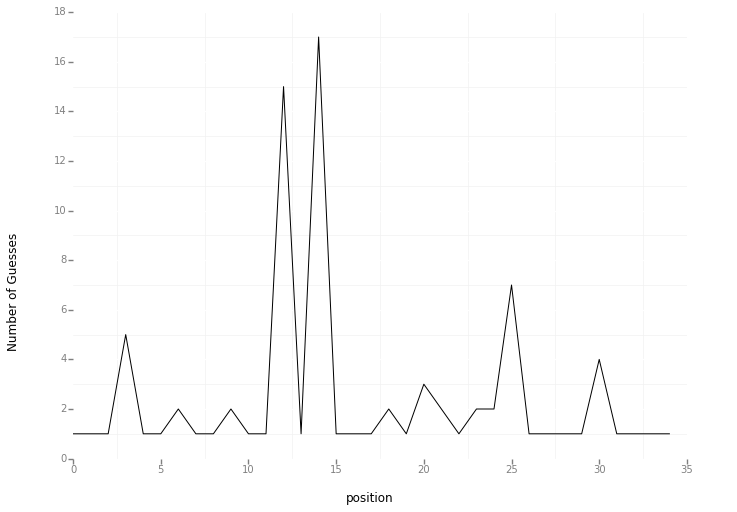

<ggplot: (8751538292912)>

In [31]:
df = pd.DataFrame({'char':sh_chars,'count':sh_counts, 'position':range(len(sh_chars))})
ggplot.ggplot(df, ggplot.aes(x='position', y='count')) + ggplot.geom_line(color='black') + ggplot.theme_bw() +\
ggplot.ylab('Number of Guesses') 
#!!! x-axis labeling and geom_text are both broken in the python version of ggplot

How many guesses does each ngram model take? Write a function that guesses character-by-character using up to the specified number of preevious characters. For example, if the specified order is 3, the first guess it should make should be made using the unigram character probabilities; the second with the bigram probabilities, and each thereafter with the trigram probabilities. In each case, try each possible continuation in descending order of their probability. Return a list of the number of counts so that we can compare it with the human data.

How does this compare with the number of guesses of a monkeys-on-typewriters model, where all characters are equally likely?

In [32]:
def getGuessCount(sh_chars, ngram, order):
    counts =[]
    output = []
    for char_index in range(len(sh_chars)):          
        preceding_context = output[max(0, char_index-(order -1)):char_index]
        
        cds = ngram[len(preceding_context)+1].keys() #cds = candidates
        #but not all of these are consistent with the preceding context
        filtered_cds = [x for x in cds if list(x)[0:len(preceding_context)] == preceding_context]
        
        filtered_counts = np.array([ngram[len(preceding_context)+1][x] for x in filtered_cds])
        if len(preceding_context) == 0:
            normalizer = float(ngram[0])
        else:
            normalizer = float(np.sum(filtered_counts))
            
        filtered_probs = filtered_counts / normalizer
        
        #reorder the candidates by their probabilities
        descending_order = np.argsort(filtered_probs)[::-1]        
        ordered_candidates = np.array(filtered_cds)[descending_order]
        
        num_guesses = np.argwhere(np.array([list(x)[-1] for x in ordered_candidates]) == sh_chars[char_index])[0][0]+1        
        # add one b/c first item is at index 0
        output.append(sh_chars[char_index])
        counts.append(num_guesses)            
    return (counts)

In [33]:
print(getGuessCount(sh_chars, ngram, 3))
print(getGuessCount(sh_chars, ngram, 2))    
print(getGuessCount(sh_chars, ngram, 1))

[3, 2, 1, 2, 2, 1, 3, 1, 1, 7, 1, 3, 19, 1, 13, 1, 2, 3, 3, 1, 6, 2, 1, 2, 1, 5, 4, 3, 8, 2, 15, 7, 2, 2, 1]
[3, 2, 1, 2, 1, 1, 3, 2, 1, 13, 2, 2, 18, 1, 11, 1, 2, 6, 3, 1, 9, 3, 1, 2, 4, 7, 4, 5, 3, 4, 17, 13, 15, 9, 3]
[3, 9, 2, 10, 2, 1, 6, 8, 1, 7, 4, 1, 10, 2, 23, 2, 10, 8, 2, 1, 4, 7, 1, 5, 1, 15, 4, 3, 4, 10, 18, 14, 18, 11, 2]


Now we add the counts to the plot

In [34]:
df['unigram'] = getGuessCount(sh_chars, ngram, 1)
df['bigram'] = getGuessCount(sh_chars, ngram, 2)
df['trigram'] = getGuessCount(sh_chars, ngram, 3)

We can plot the results of the model against the number of guesses by a person in Shannon (1951)

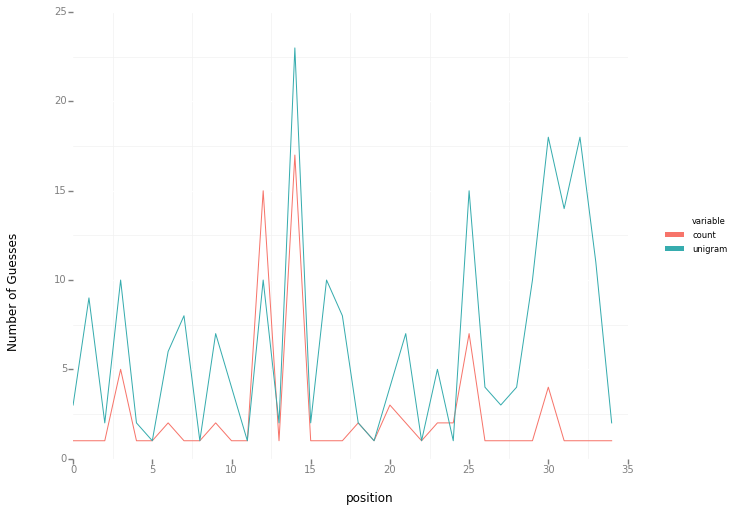

<ggplot: (8751538236662)>


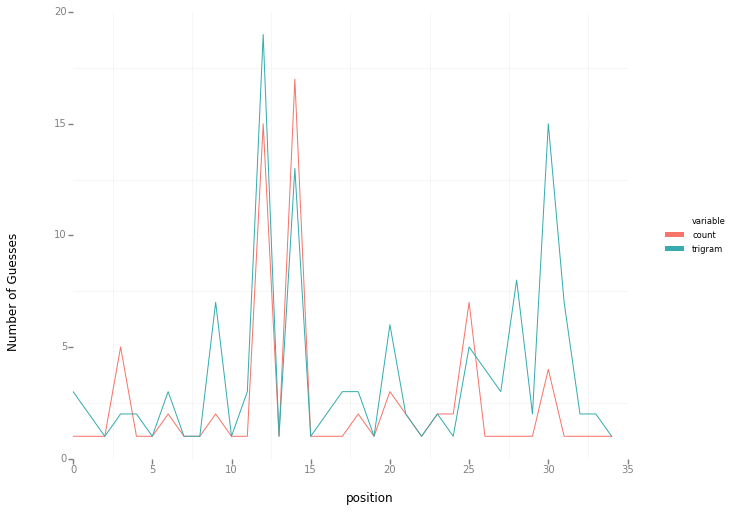

<ggplot: (-9223363285316581786)>


In [35]:
mdf = pd.melt(df, id_vars=['position'], value_vars=['count','unigram','bigram','trigram'])

print(ggplot.ggplot(mdf[mdf.variable.isin(['unigram','count'])], ggplot.aes(x='position', y='value', colour='variable')) +\
ggplot.geom_line() + ggplot.theme_bw() + ggplot.ylab('Number of Guesses'))

print(ggplot.ggplot(mdf[mdf.variable.isin(['trigram','count'])], ggplot.aes(x='position', y='value', colour='variable')) +\
ggplot.geom_line() + ggplot.theme_bw() + ggplot.ylab('Number of Guesses'))


We can also evaluate the quality of the models in terms of their root mean squared error, a single summary statistic of how many guesses each model had to make at each position compared to humans. Implement the equation (you can find it on Wikipedia or many other places) in Python. If possible, do it with vector-based operations in Numpy.  

In [36]:
def rmse(array1, array2):
    #NOT VISIBLE: Students need to implement RMSE
    return(np.sqrt(np.sum((array1 - array2)** 2.) / len(array1)))

In [37]:
np.testing.assert_allclose(rmse(df['count'],df['unigram']), 6.1990782725)
np.testing.assert_allclose(rmse(df['count'],df['bigram']), 4.97709037204)
np.testing.assert_allclose(rmse(df['count'],df['trigram']), 3.01898753132)

Now that we have functions to guess the next letter for each sentence we will try it on the set of sentences that we collected from everyone. First we download the a CSV with aggregated results:

In [48]:
import urllib
import urllib.request
fpath = 'http://cocosci.berkeley.edu/smeylan/agg.csv'
spath = 'http://cocosci.berkeley.edu/smeylan/sentences.csv'
urllib.request.urlretrieve(fpath, "web_expt_results.csv")
urllib.request.urlretrieve(spath, "sentences.csv")

('sentences.csv', <http.client.HTTPMessage at 0x7f5a047a7ef0>)

In [66]:
sentences = dict(zip(pd.read_csv('sentences.csv').id, [x.replace('_',' ') for x in pd.read_csv('sentences.csv').sentence]))

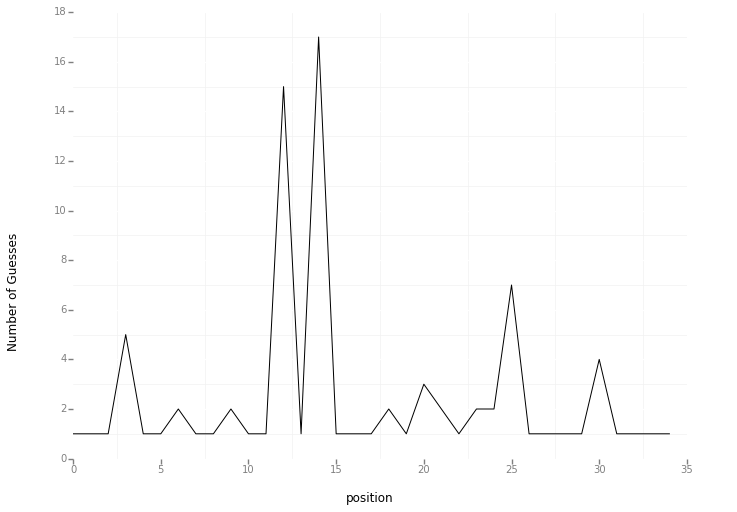

<ggplot: (8751538195839)>

In [44]:
web_expt = pd.read_csv('web_expt_results.csv')
web_expt.columns =['trial','position','count']
web_expt.iloc[0:5]

In [ ]:
ggplot.ggplot(df, ggplot.aes(x='position', y='count')) + ggplot.geom_line(color='black') + ggplot.theme_bw() +\
ggplot.ylab('Number of Guesses') 

In [ ]:
# need the original sentences in each case

In [74]:
def plotModelsForTrial(trial_index):
    df = web_expt[web_expt.trial == trial_index]
    df.sort_values(by='position')
    char_seq = list(sentences[trial_index])
    df['character'] = char_seq
    df['unigram'] = getGuessCount(char_seq, ngram, 1)
    df['bigram'] = getGuessCount(char_seq, ngram, 2)
    df['trigram'] = getGuessCount(char_seq, ngram, 3)
    
    mdf = pd.melt(df, id_vars=['position'], value_vars=['count','unigram','bigram','trigram'])

    print(ggplot.ggplot(mdf, ggplot.aes(x='position', y='value', colour='variable')) +\
    ggplot.geom_line() + ggplot.theme_bw() + ggplot.ylab('Number of Guesses'))
  

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

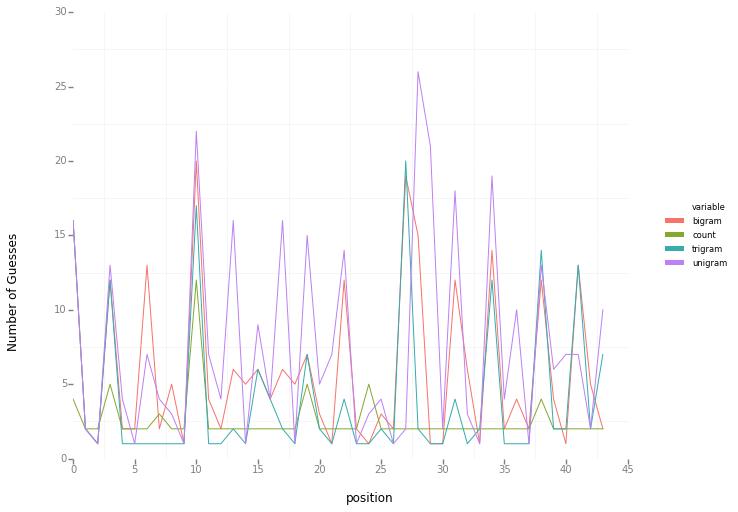

<ggplot: (8751538399166)>


In [75]:
plotModelsForTrial(1)  

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

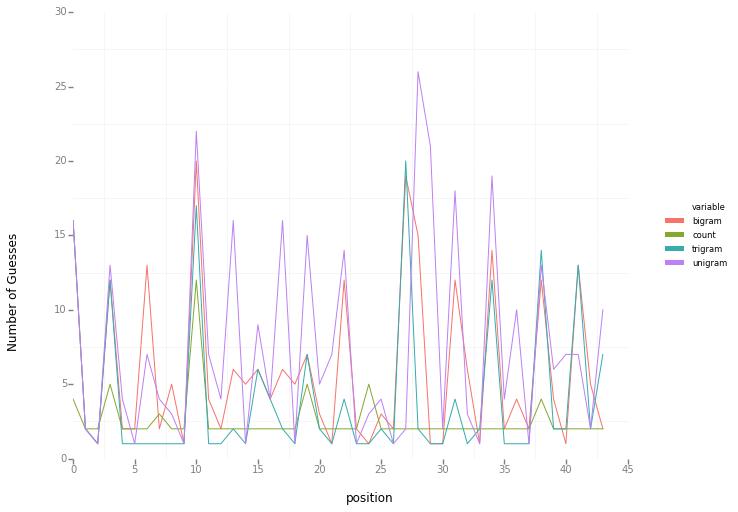

<ggplot: (-9223363285316522180)>


In [76]:
plotModelsForTrial(1)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

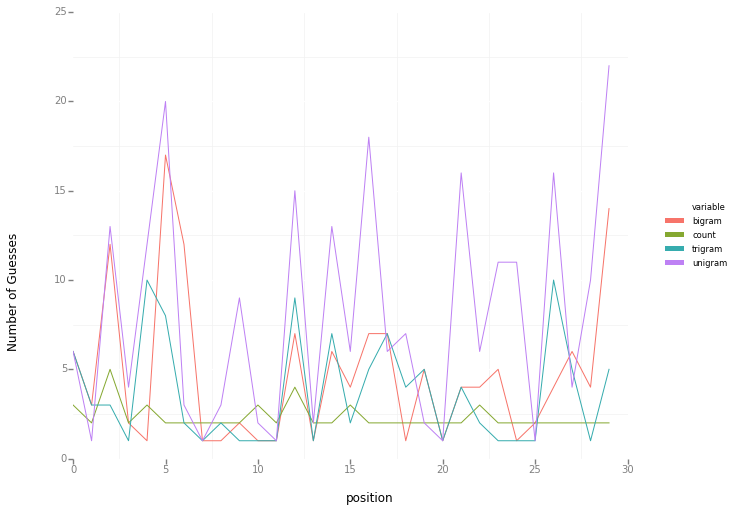

<ggplot: (-9223363285316194588)>


In [77]:
plotModelsForTrial(2)

# Probability of a held-out text

Another thing that we might want to do with the model is evaluate the probability of some text. Though we don't have estiamtes of how probable people think the continuations are, we can compare the log probability of the text to see if the data is more likely under a higher-order model. 

In [78]:
# VISIBLE
def computeProbTestSet(filename, order):
    probs_store = [] 
    with open(filename,'r') as f:
        for x in f:
            words = x.replace('\n','').split(' ')
            characters = [x.lower() for x in list(x.replace('\n',''))]        
            sequences = subsequences(characters,order)
            sentence_prob = []
            for sequence in sequences:
    #             print(sequence[2])
    #             print(''.join(list(sequence[0:2])))
    #             pdb.set_trace()
                sentence_prob.append(np.log(getProbability(sequence[order-1], list(sequence)[0:order-1], ngram)))
            probs_store.append(np.sum(sentence_prob))    
    print(np.sum(probs_store))

In [79]:
np.log((1/float(27)))*2879780 # where 2879780 is the number of characters in the test set 

-9491285.0899819471

In [80]:
computeProbTestSet('en_test_within_ascii.txt',1)

-8025236.98228


In [81]:
computeProbTestSet('en_test_within_ascii.txt',2)

-6364835.02565


In [82]:
computeProbTestSet('en_test_within_ascii.txt',3)

-4885605.8259


Note that this text file is a subsample of the original text file that we used to train the model. If we test on another file, it is very likely that higher-order models that we have built so far will fail. For example, on a test set of a different set of English movies, the unigram model is fine, but the bigram model fails:

In [83]:
computeProbTestSet('en_test_ascii.txt',1)

-7792260.22744


In [84]:
computeProbTestSet('en_test_ascii.txt',2)

KeyError: 'jk'

What is going wrong? What would we need to do to our ngram models so that they could provide us with probability estimates of new texts?

# Generating strings from the models

We might want to generate from the model...

In [85]:
# VISIBLE
def generateString(charlength, ngram, order):    
    output = []
    for char_index in range(charlength):  
        #print('New Letter')
        #print(str(max(char_index-(order -1), 0))+' - ' +str(char_index))
        preceding_context = output[max(0, char_index-(order -1)):char_index]
        #print('preceding_context: ' + ''.join(preceding_context))
        
        cds = ngram[len(preceding_context)+1].keys()
        #but not all of these are consistent with the preceding context
        filtered_cds = [x for x in cds if list(x)[0:len(preceding_context)] == preceding_context]
        #print(filtered_cds)
        
        filtered_counts = np.array([ngram[len(preceding_context)+1][x] for x in filtered_cds])
        if len(preceding_context) == 0:
            normalizer = float(ngram[0])
        else:
            normalizer = float(np.sum(filtered_counts))
            
        filtered_probs = filtered_counts / normalizer
        #print(np.sum(filtered_probs))
        
        choice = list(np.random.choice(filtered_cds, p = filtered_probs))[-1]
        #print('Choice: '+choice)
        output.append(choice)
        
    return (''.join(output))


In [86]:
generateString(100, ngram, 1)

'hlawonoisewsfo hnlssdmtewt dnintwt   yaiooi mhfhh  awsmhsreoamr sscaeo whgoriosohiaho eapiisatealiet'

In [87]:
generateString(100, ngram, 2)

'y tide y in hangedered an wasisybor che ha ither woustongamaielid am whad that yo t e w t meyoucknew'

In [88]:
generateString(100, ngram, 3)

'he lot is ot of i pme facepop is is to but way for dre seescrepossamenjuseed lewond you kinvis evat '